# Bank Marketing Data - A Multilayer Perceptron (MLP) Approach

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### Install and Load Libraries

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 181 kB 46.0 MB/s 
     |████████████████████████████████| 147 kB 41.0 MB/s 
     |████████████████████████████████| 63 kB 552 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=eae2c3ab959fb389dad4ed3fea9a9dd81f1c70e41c7cdf48bbcb63a1fb7343bb
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
# Imports
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import os

# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score
# imblearn

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1 Training



## 1.0.2 Holdout Configuration

In [ ]:
# global variables

# ratio used to split train and validation data
val_size = 0.30
# seed used to reproduce purposes
seed = 41
# reference (column) to stratify the data
stratify = "y"
# name of the input artifact
artifact_input_name = "mlops_ivan/bank_mlp/train.csv:latest"
# type of the artifact
artifact_type = "Train"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan", job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)


20-07-2022 01:18:28 Downloading and reading train artifact


In [ ]:
# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")

# split-out train/validation dataset
train, val = train_test_split(  df_train,
                                test_size=val_size,
                                random_state=seed,
                                shuffle=True
                                )

20-07-2022 01:18:28 Spliting data into train/val


In [ ]:
logger.info("train: {}".format(train.shape))
logger.info("val: {}".format(val.shape))

20-07-2022 01:18:28 train: (22152, 17)
20-07-2022 01:18:28 val: (9495, 17)


## 1.1 Data preparation

### 1.1.1 Outlier Removal

In [ ]:
logger.info("Outlier Removal")
# temporary variable
x = train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

20-07-2022 01:18:29 Outlier Removal


In [ ]:
logger.info("train shape [original]: {}".format(train.shape))
logger.info("train shape [outlier removal]: {}".format(train.loc[mask,:].shape))

20-07-2022 01:18:29 train shape [original]: (22152, 17)
20-07-2022 01:18:29 train shape [outlier removal]: (21634, 17)


In [ ]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
train = train.loc[mask,:].copy()

### 1.1.2 Balancing Data

Reference:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
train.y.value_counts()

no     19250
yes     2384
Name: y, dtype: int64

In [ ]:
# Return dataframe balanced: oversample and undersample
def resaple_bal(df, seed): 
  
  x_train = df.loc[:, df.columns != 'y']
  y_train = df.loc[:, df.columns == 'y']  
  oversample = SMOTENC(categorical_features=[1, 2, 3, 4, 6, 7, 8, 10, 15],  sampling_strategy = 0.7, random_state=seed) # 0.4
  undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=seed)
  x_train, y_train = oversample.fit_resample(x_train, y_train)
  # x_train, y_train = undersample.fit_resample(x_train, y_train)
  df_o = pd.concat([x_train, y_train], axis=1)
  df_o = df_o.sample(frac=1, random_state=seed).reset_index(drop=True)
  return df_o


In [ ]:
logger.info("Balance data")
train = resaple_bal( train, seed)

20-07-2022 01:18:29 Balance data


In [ ]:
# for validation purposes
# train.loc[0:10, 'y']

In [ ]:
# for validation purposes
train.y.value_counts()

no     19250
yes    13475
Name: y, dtype: int64

### 1.1.3 Encoding Target Variable

In [ ]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
train.loc[:, 'y'] = le.fit_transform(train.loc[:, 'y'])

# transform y_test (avoiding data leakage)
val.loc[:, 'y'] = le.transform(val.loc[:, 'y'])

val = val.reset_index(drop=True)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

20-07-2022 01:18:32 Encoding Target Variable
20-07-2022 01:18:33 Classes [0, 1]: ['no' 'yes']


### 1.1.4 Data split-out features and label

In [ ]:
x_train = train.loc[:, train.columns != 'y']
y_train = train.loc[:, train.columns == 'y']  
x_val = val.loc[:, val.columns != 'y']
y_val = val.loc[:, val.columns == 'y']  

## 1.2 Data full-pipeline

### 1.2.1 Classes and Functions for Handling Features

These custom classes and functions will handle processing the features in the pipeline

In [ ]:
def copy_exception(feature_names, exceptions):
  # this functios return the itens in the feature_names except exceptions
  # if exceptions do not exist in feature_names it returns all feature_names
  # Imput: feature_names, exceptions: list
  # Output: list
  for exception in exceptions:
    try:
      feature_names.remove(exception)
    except ValueError:
      pass
    features_selected = feature_names
  return features_selected

class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
      #exceptions = ["contact", "day", 'default', 'loan', 'marital']
      exceptions = ['default', 'loan']
      self.feature_names = copy_exception(feature_names, exceptions) 
      #self.feature_names = feature_names
    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:
            # df['job'] = df['job']

            # Combine similar jobs into categiroes
            df['job'] = df['job'].replace(['management', 'admin.'], 'white-collar')
            df['job'] = df['job'].replace(['services','housemaid'], 'pink-collar')
            df['job'] = df['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

            # minimize the cardinality poutcome
            df['poutcome'] = df['poutcome'].replace(['other'] , 'unknown')

            # minimize the cardinality month
            df['month'] = df['month'].replace(['feb', 'mar', 'jan'], '1st')
            df['month'] = df['month'].replace(['may', 'jun', 'apr'], '2st')
            df['month'] = df['month'].replace(['jul', 'aug', 'sep'], '3st')
            df['month'] = df['month'].replace(['nov', 'oct', 'dec'], '4st')         

        # update column names
        self.colnames = df.columns
        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # Map padys=-1 into a large value (1000 is used) to indicate that it is so far in the past that it has no effect
        df.loc[df['pdays'] == -1, 'pdays'] = 1000
        # update columns name
        self.colnames = df.columns.tolist()
        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values
        return df

### 1.2.2 Validation of Classes and functions to handle features

In [ ]:
# for validation purposes
f_sel = copy_exception(x_train.select_dtypes("object").columns.to_list(), ["contact", "day"])
print(f_sel)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome']


In [ ]:
# for validation purposes
x_train.month.unique()

array(['oct', 'sep', 'jun', 'may', 'aug', 'feb', 'apr', 'jul', 'mar',
       'nov', 'jan', 'dec'], dtype=object)

In [ ]:
# check the cardinality before and after transformation
x_train.select_dtypes("object").apply(pd.Series.nunique)

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [ ]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

job          7
marital      3
education    4
housing      2
contact      3
month        4
poutcome     3
dtype: int64

#### 1.2.2.1 Handling Numerical Features

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,balance,day,duration,campaign,pdays,previous
0,34,7478,30,345,1,-1,0
1,32,1954,10,107,1,-1,0
2,28,2788,6,369,2,-1,0
3,57,350,4,87,3,-1,0
4,32,1493,28,65,11,-1,0


In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[-0.64127698,  2.12070467,  1.85187016, ..., -0.54019641,
         9.64542488, -0.3552689 ],
       [-0.82838864,  0.17228003, -0.68885211, ..., -0.54019641,
         9.64542488, -0.3552689 ],
       [-1.20261197,  0.46644842, -1.19699657, ..., -0.16458177,
         9.64542488, -0.3552689 ],
       ...,
       [ 0.2007255 ,  0.12113565, -1.19699657, ..., -0.54019641,
         9.64542488, -0.3552689 ],
       [-0.36060949, -0.55608653, -0.30774377, ...,  0.58664752,
         9.64542488, -0.3552689 ],
       [ 0.85561632, -0.50776391,  1.08965348, ...,  0.58664752,
         9.64542488, -0.3552689 ]])

In [ ]:
# for validation purposes
# return columns name
nt.get_feature_names_out()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#### 1.2.2.2 Handling Categorical Features

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,housing,contact,month,poutcome
0,management,single,tertiary,no,telephone,oct,unknown
1,management,single,tertiary,yes,cellular,sep,unknown
2,blue-collar,married,secondary,yes,unknown,jun,unknown
3,management,married,tertiary,no,telephone,may,unknown
4,management,single,tertiary,yes,unknown,may,unknown


In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,housing,contact,month,poutcome
0,white-collar,single,tertiary,no,telephone,4st,unknown
1,white-collar,single,tertiary,yes,cellular,3st,unknown
2,blue-collar,married,secondary,yes,unknown,2st,unknown
3,white-collar,married,tertiary,no,telephone,2st,unknown
4,white-collar,single,tertiary,yes,unknown,2st,unknown


### 1.2.3 Data Preparation Pipeline

In [ ]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 2

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list() 

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("int64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="if_binary"))
                                       ]
                                ) # drop="first"

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipe = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [ ]:
x_train_encoded = full_pipe.fit_transform(x_train)
x_val_encoded = full_pipe.transform(x_val)

# Transform the data
# cat_names is a numpy array
cat_names = full_pipe.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipe.get_params()["num_pipeline"][2].get_feature_names_out()
# Transform the data
x_train_encoded = pd.DataFrame(x_train_encoded,columns = cat_names + num_names)
x_val_encoded = pd.DataFrame(x_val_encoded ,columns = cat_names + num_names)

In [ ]:
train_encoded = pd.concat([x_train_encoded, y_train], axis=1)
val_encoded = pd.concat([x_val_encoded, y_val], axis=1)

In [ ]:
# for validation purposes
train_encoded #.head()

,job_blue-collar,job_entrepreneur,job_other,job_pink-collar,job_self-employed,job_technician,job_white-collar,marital_divorced,marital_married,marital_single,...,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,y
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,34.0,7478.0,30.0,345.0,1.0,1000.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,32.0,1954.0,10.0,107.0,1.0,1000.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,28.0,2788.0,6.0,369.0,2.0,1000.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,57.0,350.0,4.0,87.0,3.0,1000.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,32.0,1493.0,28.0,65.0,11.0,1000.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32720,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,51.0,-437.0,30.0,130.0,3.0,1000.0,0.0,0
32721,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,26.0,620.0,22.0,223.0,1.0,94.0,1.0,1
32722,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,43.0,1809.0,6.0,312.0,1.0,1000.0,0.0,1
32723,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,37.0,-111.0,13.0,147.0,4.0,1000.0,0.0,0


### 1.2.4 Export the data pipeline and transformed data

In [ ]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [ ]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(full_pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

20-07-2022 01:18:34 Dumping the artifacts to disk


['target_encoder']

In [ ]:
# saving transformed train data to csv
train_encoded.to_csv("encoded_train_data.csv", index=False)
val_encoded.to_csv("encoded_val_data.csv", index=False)
#run = wandb.init(project="bank_mlp", entity="mlops_ivan", job_type="encode_data")

In [ ]:
# Uploading Transformed Data
# Create a new artifact and configure with the necessary arguments
artifact = wandb.Artifact(name="encoded_train_data.csv",
                          type="encoded_data",
                          description="Upload encoded Train Data")

artifact.add_file("encoded_train_data.csv")
run.log_artifact(artifact)

# Uploading Transformed Data
# Create a new artifact and configure with the necessary arguments
artifact = wandb.Artifact(name="encoded_val_data.csv",
                          type="encoded_data",
                          description="Upload encoded Val Data")

artifact.add_file("encoded_val_data.csv")
run.log_artifact(artifact)

# Data pipeline model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full data pipeline composed of a Preprocessing Stage for bank marketing model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

20-07-2022 01:18:35 Logging model artifact
20-07-2022 01:18:35 Logging target enconder artifact


In [ ]:
run.finish()

os.remove('encoded_train_data.csv')
os.remove('encoded_val_data.csv')

## 1.3 Hyperparameter Tuning

### 1.3.1 Monitoring a neural network

#### 1.3.1.1 Install and Load Libraries

In [ ]:
!pip install wandb

In [ ]:
!pip install tensorflow_addons

In [ ]:
import wandb
import logging
from wandb.keras import WandbCallback
import pandas as pd
import numpy as np
import os

from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential
from keras import callbacks
# from keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

from keras.constraints import max_norm
import matplotlib.pyplot as plt

In [ ]:
# os.environ['WANDB_NOTEBOOK_NAME'] = 'train_test.ipynb'

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

#### 1.3.1.2 Load settings and data

In [ ]:
# Default values for hyperparameters
defaults = dict(layer_1 = 27,
                layer_2 = 59,
                learn_rate = 0.1,
                batch_size = 1024,
                epoch = 500,
                dropout1 = 1.0,
                dropout2 = 0.7,
                l2_1 = 0.0001,
                l2_2 = 0.001,
                gradient_cliping = 1,
                bath_norm = 1
                )

# defaults = dict(layer_1 = 23,
#                 layer_2 = 39,
#                 learn_rate = 0.1,
#                 batch_size = 256,
#                 epoch = 500,
#                 dropout1 = 1.0,
#                 dropout2 = 0.5,
#                 l2_1 = 0.0,
#                 l2_2 = 0.0001,
#                 gradient_cliping = 1,
#                 bath_norm = 1
#                 )

# Default values for hyperparameters
# defaults = dict(layer_1 = 32,
#                 layer_2 = 32,
#                 learn_rate = 0.01,
#                 batch_size = 4096,
#                 epoch = 500,
#                 dropout1 = 1.0,
#                 dropout2 = 1.0,
#                 l2_1 = 0.0,
#                 l2_2 = 0.0,
#                 gradient_cliping = 0,
#                 bath_norm = 1
#                 )
# Better Genaralization
# 1. Regularization L2 ok
# 2. Penalize large weights 
# 3. weight constraint
# 4. Dropout ok
# 5. Noise ok (oversample)
# 6. Early stoping ok

In [ ]:
run = wandb.init(project="bank_mlp", entity="mlops_ivan", config= defaults, name="run_01")
config = wandb.config

Acc,0.8482
F1,0.51104
Precision,0.41006
Recall,0.67801


In [ ]:
# Downloading and reading encoded train val artifact
logger.info("Downloading and reading encoded train artifact")
local_path = run.use_artifact("encoded_train_data.csv:latest").file()
train_encoded = pd.read_csv(local_path)

logger.info("Downloading and reading encoded val artifact")
local_path = run.use_artifact("encoded_val_data.csv:latest").file()
val_encoded = pd.read_csv(local_path)

x_train_encoded = train_encoded.loc[:, train_encoded.columns != 'y']
y_train = train_encoded.loc[:, train_encoded.columns == 'y']  
x_val_encoded = val_encoded.loc[:, val_encoded.columns != 'y']
y_val = val_encoded.loc[:, val_encoded.columns == 'y'] 

20-07-2022 02:33:01 Downloading and reading encoded train artifact
20-07-2022 02:33:01 Downloading and reading encoded val artifact


In [ ]:
train_encoded.y.value_counts()

0    19250
1    13475
Name: y, dtype: int64

#### 1.3.1.3 Instantiate and train a classification model

In [ ]:
# Instantiate a classification model
model = tf.keras.Sequential()
if config.l2_1!=0.0:
  model.add(layers.Dense( config.layer_1,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_1),
                dtype='float64'))
else:
  model.add(layers.Dense( config.layer_1,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                dtype='float64'))
if config.bath_norm==1.0:
  model.add(layers.BatchNormalization())
if config.dropout1!=1.0:
  model.add(layers.Dropout(config.dropout1))
if config.l2_2!=0.0:
  model.add(layers.Dense( config.layer_2,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_2),
                dtype='float64'))
else:
  model.add(layers.Dense( config.layer_2,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                dtype='float64'))
if config.bath_norm==1:
  model.add(layers.BatchNormalization())
if config.dropout2!=1.0:
  model.add(layers.Dropout(config.dropout2))
model.add(layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64'))

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
m_f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
m_bacc_score = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
m_recall = tf.keras.metrics.Recall(thresholds=0.5)
m_precision = tf.keras.metrics.Precision(thresholds=0.5)

# Instantiate an optimizer.
if config.gradient_cliping==0.0:
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learn_rate)
else:
    optimizer = tf.keras.optimizers.Adam( 
                                    learning_rate=config.learn_rate,
                                    clipvalue= config.gradient_cliping
                                    )

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[m_f1_score,
                                                       m_bacc_score,
                                                       m_recall,
                                                       m_precision                                                                                                          
                                                       ]) 

In [ ]:
early_stopping = callbacks.EarlyStopping(
                monitor='val_f1_score',   # 'loss'  "val_loss"           
                min_delta=0.001, # Minimum change
                patience=100, # Number of epochs with no improvement
                verbose=1, # 
                mode='max', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

In [ ]:
# %%wandb
# Add WandbCallback() to the fit function
hist = model.fit(x= x_train_encoded , # full_pipe.transform(x_train)
          y= y_train,
          batch_size=config.batch_size,
          epochs=config.epoch,
          validation_data=( x_val_encoded, y_val), # full_pipe.transform(x_val_bal)
          callbacks=[ WandbCallback(monitor="val_f1_score",
                                  mode="max",
                                  training_data=(x_train_encoded, y_train),
                                  validation_data=(x_val_encoded, y_val),
                                  save_model="True",
                                  log_weights=True),
                                  early_stopping],
                                  verbose=1)

# predict
y_pred = np.rint(model.predict(x_val_encoded)).ravel()

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val.values.ravel(), y_pred, beta=1, zero_division=1)
precision = precision_score(y_val.values.ravel(), y_pred, zero_division=1)
recall = recall_score(y_val.values.ravel(), y_pred, zero_division=1)
acc = accuracy_score(y_val.values.ravel(), y_pred)
#g_mean = geometric_mean_score(y_val.values.ravel(), y_pred)

logger.info("val_Accuracy: {}".format(acc))
logger.info("val_Precision: {}".format(precision))
logger.info("val_Recall: {}".format(recall))
logger.info("val_F1: {}".format(fbeta))
#logger.info("val_G-Mean: {}".format(g_mean))

run.summary["val_Accuracy"] = acc
run.summary["val_Precision"] = precision
run.summary["val_Recall"] = recall
run.summary["val_F1"] = fbeta
#run.summary["val_G-Mean"] = g_mean  

In [ ]:
# f1_score: 0.8185 - binary_accuracy: 0.8474 - recall: 0.8359 - val_loss: 0.2815 - val_f1_score: 0.5754 - val_binary_accuracy: 0.8824 - val_recall: 0.6577 - _timestamp: 1658259016.0000 - _runtime: 294.0000

In [ ]:
model.evaluate(x_val_encoded,y_val)

In [ ]:
model.summary() # mostra modelo

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc = 'upper left')

In [ ]:
plt.plot(hist.history['binary_accuracy'])
plt.plot(hist.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')

In [ ]:
plt.plot(hist.history['f1_score'])
plt.plot(hist.history['val_f1_score'])
plt.title('Model f1 score')
plt.xlabel('Epoch')
plt.ylabel('f1')
plt.legend(['Train', 'Val'], loc = 'upper left')

#### 1.3.1.4 Save the model

In [ ]:
model.save(os.path.join(wandb.run.dir, "model.h5"))

In [ ]:
run.finish()

### 1.3.2 Sweeps

In [ ]:
def train_func():

     # The sweep calls this function with each set of hyperparameters
    # Default values for hyperparameters
    defaults = dict(layer_1 = 32,
                layer_2 = 32,
                learn_rate = 0.001,
                batch_size = 512,
                epoch = 300,
                dropout1 = 0.9,
                dropout2 = 0.9,
                l2_1 = 0.0,
                l2_2 = 0.0,
                gradient_cliping = 2,
                bath_norm = 1)
    
    fmonitor = "val_f1_score"
    
    # Initialize a new wandb run
    wandb.init(project="bank_mlp", entity="mlops_ivan", config= defaults)
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Instantiate a simple classification model
# Instantiate a simple classification model
    # Instantiate a simple classification model
    model = tf.keras.Sequential()
    if config.l2_1!=0.0:
      model.add(layers.Dense( config.layer_1,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_1),
                    dtype='float64'))
    else:
      model.add(layers.Dense( config.layer_1,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    dtype='float64'))
    if config.bath_norm==1.0:
      model.add(layers.BatchNormalization())
    if config.dropout1!=1.0:
      model.add(layers.Dropout(config.dropout1))
    if config.l2_2!=0.0:
      model.add(layers.Dense( config.layer_2,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_2),
                    dtype='float64'))
    else:
      model.add(layers.Dense( config.layer_2,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    dtype='float64'))
    if config.bath_norm==1:
      model.add(layers.BatchNormalization())
    if config.dropout2!=1.0:
      model.add(layers.Dropout(config.dropout2))
    model.add(layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64'))
    
    
    # Instantiate a logistic loss function that expects integer targets.
    loss = tf.keras.losses.BinaryCrossentropy()

    # Instantiate an accuracy metric.
    m_f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    m_bacc_score = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
    m_recall = tf.keras.metrics.Recall(thresholds=0.5)
    m_precision = tf.keras.metrics.Precision(thresholds=0.5)

    # Instantiate an optimizer.
    if config.gradient_cliping==0.0:
        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learn_rate)
    else:
        optimizer = tf.keras.optimizers.Adam( 
                                        learning_rate=config.learn_rate,
                                        clipvalue= config.gradient_cliping
                                        )

    # configure the optimizer, loss, and metrics to monitor.
    model.compile(optimizer=optimizer, loss=loss, metrics=[m_f1_score,
                                                          m_bacc_score,
                                                          m_recall,
                                                          m_precision                                                                                                          
                                                          ]) 

    early_stopping = callbacks.EarlyStopping(
                monitor=fmonitor,   # 'loss'  "val_loss"           
                min_delta=0.001, # Minimum change
                patience=50, # Number of epochs with no improvement
                verbose=1, # 
                mode='max', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

    model.fit(x= x_train_encoded , # full_pipe.transform(x_train)
              y= y_train,
              batch_size=config.batch_size,
              epochs=config.epoch,
              validation_data=( x_val_encoded, y_val), # full_pipe.transform(x_val)
              callbacks=[
                          WandbCallback(monitor=fmonitor,
                                  mode="max",
                                  training_data=(x_train_encoded, y_train),
                                  validation_data=(x_val_encoded, y_val),
                                  save_model="True",
                                  log_weights=True),
                                  early_stopping],
                                  verbose=0)
    
    y_pred = np.rint(model.predict(x_val_encoded)).ravel()

    # Evaluation Metrics
    fbeta = fbeta_score(y_val.values.ravel(), y_pred, beta=1, zero_division=1)
    precision = precision_score(y_val.values.ravel(), y_pred, zero_division=1)
    recall = recall_score(y_val.values.ravel(), y_pred, zero_division=1)
    acc = accuracy_score(y_val.values.ravel(), y_pred)
    g_mean = geometric_mean_score(y_val.values.ravel(), y_pred)

    metrics = { "val_accuracy": acc,
                "val_precision": precision,
                "val_recall": recall,
                "val_F1": fbeta,
                "val_G-Mean": g_mean
                }
    wandb.log(metrics) 

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.

sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'binary_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'layer_1': {
            'max': 25,
            'min': 18,
            'distribution': 'int_uniform',
        },
        'layer_2': {
            'max': 46,
            'min': 37,
            'distribution': 'int_uniform',
        },
        'learn_rate': {
            'min': -3,
            'max': -2,
            'distribution': 'log_uniform', #  log_uniform
        },
        'batch_size': {
            'values': [256,1024,4096]
        },
        'epoch': {
            'values': [500]
        },
        'dropout1': {
            'values': [0.7,0.8,0.9,1.0] 
        },
        'dropout2': {
            'values': [0.7,0.8,0.9,1.0] 
        },
        'l2_1': {
            'values': [0.001,0.0001,0.00001]  
        },
        'l2_2': {
            'values': [0.001,0.0001,0.00001]  
        },
        'gradient_cliping': {
            'values': [0.0,0.5,1.0]
        },
        'bath_norm': {
            'values': [1]
        }
    }
}

# sweep_config = {
#     'method': 'random', #grid, random
#     'metric': {
#       'name': 'binary_accuracy',
#       'goal': 'maximize'   
#     },
#     'parameters': {
#         'layer_1': {
#             'max': 64,
#             'min': 16,
#             'distribution': 'int_uniform',
#         },
#         'layer_2': {
#             'max': 64,
#             'min': 16,
#             'distribution': 'int_uniform',
#         },
#         'learn_rate': {
#             'min': -3,
#             'max': -2,
#             'distribution': 'log_uniform', #  log_uniform
#         },
#         'batch_size': {
#             'values': [256,1024,4096,8192]
#         },
#         'epoch': {
#             'values': [500]
#         },
#         'dropout1': {
#             'values': [0.5,0.7,0.9,1.0] 
#         },
#         'dropout2': {
#             'values': [0.5,0.7,0.9,1.0] 
#         },
#         'l2_1': {
#             'values': [0.01,0.001,0.0001,0.0]  
#         },
#         'l2_2': {
#             'values': [0.01,0.001,0.0001,0.0]  
#         },
#         'gradient_cliping': {
#             'values': [0.0,0.5,1.0]
#         },
#         'bath_norm': {
#             'values': [0,1]
#         }
#     }
# }

# sweep_config = {
#     'method': 'random', #grid, random
#     'metric': {
#       'name': 'binary_accuracy',
#       'goal': 'maximize'   
#     },
#     'parameters': {
#         'layer_1': {
#             'max': 48,
#             'min': 8,
#             'distribution': 'int_uniform',
#         },
#         'layer_2': {
#             'max': 48,
#             'min': 8,
#             'distribution': 'int_uniform',
#         },
#         'learn_rate': {
#             'min': -4,
#             'max': -2,
#             'distribution': 'log_uniform', #  log_uniform
#         },
#         'batch_size': {
#             'values': [32,128,256,1024,4096]
#         },
#         'epoch': {
#             'values': [200,300,500]
#         },
#         'dropout1': {
#             'min': 0.3,
#             'max': 0.99,
#             'distribution': 'uniform',  
#         },
#         'dropout2': {
#             'min': 0.3,
#             'max': 0.99,
#             'distribution': 'uniform',  
#         },
#         'l2_1': {
#             'min': 0.0,
#             'max': 0.01,
#             'distribution': 'uniform',  
#         },
#         'l2_2': {
#             'min': 0.0,
#             'max': 0.01,
#             'distribution': 'uniform',  
#         },
#         'gradient_cliping': {
#             'values': [0.0,0.5,1.0]
#         },
#         'bath_norm': {
#             'values': [0,1]
#         }
#     }
# }

In [ ]:
# Initialize a new sweep

sweep_id = wandb.sweep(sweep_config, entity="mlops_ivan", project="bank_mlp")

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. learn_rate uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.


Create sweep with ID: nmtkicwa
Sweep URL: https://wandb.ai/mlops_ivan/bank_mlp/sweeps/nmtkicwa


In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id = sweep_id, function=train_func,count=40)

wandb: Agent Starting Run: 53yi9t6o with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 20
wandb: 	layer_2: 39
wandb: 	learn_rate: 0.08772367686536392
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 78.
Epoch 128: early stopping


binary_accuracy,▃▆▂▄▃▂▃▁▂▂▂▃▄▆▅▂▅▅▄▄▄▇█▅▇▆▄▆▆▆▆▇▆▇▇█▄█▇▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄▆▂▄▃▁▂▁▃▂▃▅▄▅▆▁▅▅▃▄▄▇▆▅█▅▃▄▅▅▅█▅▅▇▇▄█▆▅
loss,█▃▇▄▆▆▆▆▆▅▅▆▄▃▃▆▄▆▄▅▂▂▁▃▄▃▅▃▃▃▇▂▁▅▁▄▃▂▂▆
precision,▂▅▂▃▂▃▃▁▁▂▂▁▄▆▄▄▅▄▄▄▅▆█▄▅▇▆█▆▅▅▆▆█▇▇▅▇▇▅
recall,▆▆▄▅▅▂▃▃▆▄▅█▅▅▇▁▅▆▄▅▄▆▅▅█▄▁▂▄▅▅█▄▃▆▆▄█▅▅
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▂▅▆▃▇▆▇▆▄▄▄▇▄▅▃▆▄▁▃▅▄▄█▆▇█▆▇▅▆▇▂▅▆▇▅▁▆▄▄
val_f1_score,▂▆▇▃▇▇▇▇▄▅▄▆▅▆▃▆▅▁▃▅▄▄▅▇█▇▇▇▆▆▇▂▅▆▇▆▁▇▄▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z9gjd6rc with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 18
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.08352630246234974
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 127.
Epoch 177: early stopping


binary_accuracy,▁▃▃▅▅▆▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆█▇▇▇▇▅▅▅▇▇▇█▇█▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▃▃▅▅▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▆▆▆▇▇▇█▇█▇
loss,█▆▇▄▄▃▅▃▂▂▂▂▂▂▁▁▂▂▂▂▁▂▂▂▂▁▂▂▂▁▃▄▃▂▃▁▁▂▁▂
precision,▁▂▃▃▄▅▁▄▆▇▇▇▆▇▇▇▇▇▇▇█▇▆▇▇█▇▆▆▇▅▄▄▇▆██▇▇▇
recall,▁▃▃▆▆▇▆▇▇▇▇▇█▇█▇▇▇▇▇▇█▇▇▇█▇█▇▇▆▇▇▇▇▇▇▇██
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▄▆▁▄▄▃▇▆▇▇▇▅▇▆▇▇▃▆▄▇▅██▅▇▄▆█▆▆▇▇▅▅█▇▆▇█
val_f1_score,▄▃▅▁▃▄▂▇▆▇▇▇▄█▆▇▇▃▆▄▇▅██▅▇▃▆█▆▅▇▆▅▅██▅▇█


wandb: Agent Starting Run: cwbjk4el with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.8
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 23
wandb: 	layer_2: 37
wandb: 	learn_rate: 0.12941854136993863
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 39.
Epoch 89: early stopping


binary_accuracy,▁▆▆▇▇▇█▆▇▇▇▆▇▇▇▇▇▇▇█▇▇█▇▇▇█▇█▇██▇█▇▇▇▇▆▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▆▇▇▇▇▆█▇▇▇█▇██▇▇▇█▇█▇▇▆▇
loss,█▃▄▃▁▂▁▅▃▂▂▄▃▄▃▃▃▄▃▃▅▄▁▂▃▂▂▃▂▃▃▃▁▂▂▁▂▂▃▄
precision,▁▇▆▇█▇█▆▇▇█▇▇▇▇▇▇▇██▇▇█▇▇▇█▇█▇▇█▇▇▇▇▇▇▆▇
recall,▁▆▆▆▆▇▇▆▇▇▇▆▇▇▇▆▆▇▇▇▇▆█▇▇▇█▇▇█▇▆▇▇▇█▇▇▆▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▄▅▅▅▇▆██▇▆▂▃▆▇▃▄▄▇▄▆▆▃▅▇▆▆▆▁█▅▁▇▆▂▇▆▆▆▇█
val_f1_score,▇▇▇▇██▇▁██▇▇█▆▇▇▇█▇▇▇▇▇▆▇▇▇▇▇█▇██▇█▇█▇▇▇


wandb: Agent Starting Run: f3xkq852 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.8
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 0.001
wandb: 	layer_1: 21
wandb: 	layer_2: 46
wandb: 	learn_rate: 0.08764828230967292
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping


binary_accuracy,▁▅▇▇▇▇▇▇▇▇▇█████████▇█▇█████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
f1_score,▁▅▇▇▇▇▇▇▇█▇█████████▇█▇█████████████████
loss,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▅▇▇▇▇▇█▇▇▇██▇██▇█▇▇▇███▇▇██████████████
recall,▁▄▆▇▇▇▇▇▇█▇▇▇█▇█████▇▇▇████▇▇▇█▇█████▇█▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▁▆▇▇▇▇▇█████▇███▇██▇▇▇██▇██▇▇▇▇▇▇▇▇▇▇▇▇
val_f1_score,▅▁▆▆▇▇▇▇█████▇███▇█▇▇▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇▇


wandb: Agent Starting Run: i2mukfkm with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 20
wandb: 	layer_2: 46
wandb: 	learn_rate: 0.05994502484623131
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


binary_accuracy,▁▇▇█▇██████████████████████▇███▇▇███████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇▇██████▇▇█▇██▇██████▇██▇███▇▇███████
loss,█▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁
precision,▁▇▇▇▇▇▇█▇▇█████▇███▇█▇▇█▇▇█▇▇▇▇▇▇█▇▇██▇█
recall,▁▅▇▇▇▇▇▇██▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▄▅▅▆▆▇▇▆▇▁▆▇▇██▇▇▇██████▆▇▆▆▇█▅▅▆▆▇▇▇▇▇
val_f1_score,▄▃▅▄▅▆▇▆▆▆▁▆▇▇█▇▇▇▇██▇▇█▇▆▇▅▅▇▇▄▄▅▅▇▇▇▇▇


wandb: Agent Starting Run: v1js363w with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 21
wandb: 	layer_2: 37
wandb: 	learn_rate: 0.08153293847219707
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping


binary_accuracy,▁▅▆▆▅▆▆▆▆▆▇▇▆▇▆▆▆▆▆▆▆█▇█▄▆▆▆▆▆▆▆▆▆▆▆▆▅▆▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▆▆▆▆▆▆▆▆▇▇▇▇▇▆▆▆▆▆▆█▇█▅▆▆▆▆▆▆▆▆▆▆▇▆▆▇▇
loss,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▄▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃
precision,▁▄▅▆▄▅▅▅▅▅▆▅▆▅▄▅▅▆▆▅▅▆▅█▂▄▄▄▄▅▅▄▆▅▅▅▄▂▂▄
recall,▁▄▅▅▅▅▅▅▅▅▆▇▆▆▇▅▆▅▅▅▅▇▆▆▅▆▅▆▆▅▆▆▅▅▅▆▆▇█▆
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▂▁▆▇▆▇███████▇▂▇██████▇▁▃▄▄▆▅▆▆▆▇▇█▇▇█▆
val_f1_score,▅▆▅▇█▇▇▇▇▄▃▁▇▃█▆████▄▁▆▅▆▆▆▇▇▇▇▇▇██▇▆█▂▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bwrxw3cx with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.8
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 18
wandb: 	layer_2: 46
wandb: 	learn_rate: 0.08033017676542914
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 135.
Epoch 185: early stopping


binary_accuracy,▁▆▇▇▇▇▇▇▇▇▇███▇▇█▇████████▇▇████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇███▇██▇███▇██▇██████████████████████
loss,█▄▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▆▆▆▆▆▇▇▇▇█▇█▇█▇▇▇█▇▇▇▇▇▇▇▇▇███▇███▇▇██▇
recall,▁▆▇▇██▇▇█▇▇███▇██▇████████▇▇█████▇██████
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▃▇▆▅▆▆▆▆▇▇█▇█▇██▇▇██▇▇▆▆▆██▇██▇█▇▇▆█▇▇▆
val_f1_score,▁▃▇▆▅▆▆▆▆▇▇▇▆▇▆▇▇▇▇▇▇▇▇▆▆▆▇█▇██▇█▇▇▆█▇▇▆


wandb: Agent Starting Run: sggy6i2a with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.8
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 21
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.05715946394539067
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


binary_accuracy,▁▃▅▇▇█▇▇█▇▇█████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▂▁▅▇▇█▇▇████████████████████████████████
loss,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▄▆▇▇████▇██████████████████████████████
recall,▂▁▅▇▇▇▇▇██▇███████████████████████████▇█
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁█▄▇▇▇▇▇▇▇▇▇▆▇▇▆▆▆▆▇▇▇▇▆▆▆▆▆▇▆▆▆▇▆▆▇▇▇▇▇
val_f1_score,▁▆▆███▇███▇█▇▇█▇▇▇▇████▇▇▇▇▇█▇▇██▇▇█████


wandb: Agent Starting Run: 1yrs7m4i with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 19
wandb: 	layer_2: 45
wandb: 	learn_rate: 0.050336173292417755
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 75.
Epoch 125: early stopping


binary_accuracy,▁▆▇▇██▇█▇█▇█▇█▇██▇████████████████████▇█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▇▇████████▇████▇██████▇███████████████
loss,█▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▆▇▇█▇▇▇▇█▇▇▇█▇██▇▇▇███▇██▇██████▇▇█▇▇▇█
recall,▁▇▇▇▇███▇█▇█▇▇██▇▇██▇▇▇█▇██▇█▇██▇█████▇▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▄▂▆▆▆▇▅▆▅▆▅▇▅▆▆▇▆▆▆▆▇▆▆▅▆▇▆▆█▆▆▆▇▇█▇▅▇▇
val_f1_score,▁▄▂▆▆▆▇▅▆▅▆▅▆▅▆▆▇▆▆▆▆▇▆▅▅▆▇▆▆█▆▇▆▆▇█▇▅▇▇


wandb: Agent Starting Run: or74r3x8 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 24
wandb: 	layer_2: 42
wandb: 	learn_rate: 0.10628661687154176
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 14.
Epoch 64: early stopping


binary_accuracy,▁▇▇▇▇█▇▇█████▇▇▇▇▇▆▇█▇▇▇█▇▇▇▇▇▇▇▇█▇▇███▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇█▆██▇▇█████▇▇█▇▇▆██▇▇▇███▆▇▇▇▇▇█▇▇████
loss,█▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▆▆▇▇▇▇▇█▇██▇▆▇▆▇▆▇▆██▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
recall,▁▆█▃▆▆▆▄▅▆▆▅▅▆▅▇▆▇▃▇▅▃▅▅▅▆▆▄▅▅▄▆▆▇▆▅▆▇▆▆
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▇▅▆▄█▁██▇▇▆▆▆▅▆▅▅▂▆▇▇▆▇█▇▇█▇█▇▇█▇▇▆▇█▅▆
val_f1_score,▆▇▆▆▄▇▁██▇█▇▆▆▅▆▅▅▂▇▇▇▆▇█▇▇█▇█▇▇█▇▆▆▇█▅▆


wandb: Agent Starting Run: 3gzh8ltd with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 24
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.12586374155486266
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 62.
Epoch 112: early stopping


binary_accuracy,▁▇▇▇▆▆▆▇▆▆▆▇▆█▇█▇▇▇███▇█▇▇▆▇▇▇████▇▇██▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇██▆▆▆▇▆▆▆▇▆▇▇▇▇▇▇███▇█▇▇▆▇▇▇███▇████▆▇
loss,█▃▂▂▃▃▃▃▄▄▃▂▃▁▂▂▃▃▃▃▃▃▃▂▃▄▄▂▃▂▂▂▁▂▂▃▁▁▃▃
precision,▁▆▆▆▆▇▆▇▆▆▇▇▆█▇█▇▆▇▇▇█▆▇▇▆▅▇▇▇█▇▇█▇▆█▇▇▇
recall,▁███▅▆▆▇▅▆▅▆▆▇▇▇▆█▇████▇▇▇▆▆▇▇███▇████▆▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▇▅▅▅▃▄▇▄▇▁▆▆▄▆▆▅▆█▆▅▅▄▇▇▃▄▃▆▇▅▄▆▅▁█▃▇█▄
val_f1_score,▇▆▆▅▅▃▄▇▅▇▁▆▆▄▆▅▆▅▇▆▅▆▄▇▇▃▄▄▆▇▅▄▇▆▁█▃██▄


wandb: Agent Starting Run: fpbk9gxr with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 18
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.09115326129427412
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 52.
Epoch 102: early stopping


binary_accuracy,▁▄▆▆▆▇▇▇▇█▇█████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▁▅▆▆▆▆▇▇▇██▇███████████████████████████
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▆▇▇▇██▇████████████████████████████████
recall,▂▁▄▅▆▆▆▆▇▇▇▇▇███████▇██▇██▇█████████████
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▁▃▃▁▅▄▆▅▅▅▅▅▅▅▆▅▅▅▅▆▅▆▅▆▅▅▅▅▆▅▅▆▅▅▅▅▅▆▆
val_f1_score,▁▃▄▅▃▇▆▇▇▇▆▇▆▇▇█▇▇▇▇█▇█▇▇▇▇▇▇█▇▇█▇▇▇▇▇██


wandb: Agent Starting Run: 12qa7xpc with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 19
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.07884085173112795
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 73.
Epoch 123: early stopping


binary_accuracy,▁▅▅▅▅▅▅▅▅▅▆▆▅▆▆▆▅▆▆▆▇▇▆▇▅▆▇██▅▆▆▆▆▆▅▆▇▆▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▅▅▅▅▅▅▅▅▆▆▅▅▆▆▅▅▅▆▇▇▇▇▅▆▇██▆▆▆▆▆▅▆▆▇▆▆
loss,█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▃▂▂▁▁▃▃▂▂▃▃▃▂▂▂▃
precision,▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▆▆▆▆▇▇█▅▆▆▆▆▆▅▇▇▇▅
recall,▁▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▆▆▆▇▄▅▇██▆▅▆▆▅▅▆▆▆▅▆
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▄▄▅▆▆▆▇▇▇█████▆█▃▆▇███▇█▁▇██▇▅▁█▆▅▃▁█▇▇▅
val_f1_score,▄▆▆▇▇▇███▂▃▅█▇▇█▅▇▇▅▁▅▆█▄▇▁▆▇▆▄█▇▆▅▄▃█▇▆


wandb: Agent Starting Run: 402t3ngs with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 20
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.05572409262262874
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 56.
Epoch 106: early stopping


binary_accuracy,▁▅▅▅▆▆▇▇█████████▇▇▇████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▅▅▆▆▇▇█████████▇▇█████████████████████
loss,█▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▆▆▆▆▇▇▇█▇███▇███▇▇▇▇███████▇███████████
recall,▁▃▅▄▅▆▇▇█▇▇███▇███▇▇███▇███████████████▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▅▆▆▇▁▅▆▄▂▄▄▇█▇▇█▆▇▆█▇▇█▇▇▆▇▇▇█▇▆▇▇▇▇▆▇▆
val_f1_score,▅▄▅▅▂▁▄▅▃▂▃▃▆▇▇▇█▅▇▆██▇█▇▇▆▇▇▇█▇▆▇▇▇▇▆▇▆


wandb: Agent Starting Run: yw1pulu3 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 23
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.049878492117867344
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


binary_accuracy,▁▂▂▃▄▅▆▇▇▅▇▇▆▇█▇▇▇▇█▇▂▂▃▄▇▇▇█▇█▇████▇██▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▂▂▃▄▅▇▇▇▅▇▇▆▇█▇▇▇▇██▂▂▃▄▇▇▇█▇█▇████▇██▇
loss,█▇▇▆▅▄▃▂▂▅▃▂▄▂▂▂▂▂▂▁▁▇▇▇▆▃▂▂▂▂▂▃▁▂▁▁▂▂▁▂
precision,▁▃▃▃▃▆▆▇▇▅▆▇▆▆█▇▇▇▇█▇▃▃▃▅▇███▇▇▇████▇██▇
recall,▁▂▂▃▅▅▇▇▇▅▇▇▆▇██▇▇▇██▂▂▃▄▇▇▇█▇█▇████▇██▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▅▆▇█▇█▃▇█▂█████▇▇▁██▄▆██▇▅▄▁▆▇▃▇▇███▇█▆
val_f1_score,▇▆▇▇▇▇▇▅█▁▄▇▅▆▇▇▇▆▄██▅▆▅▆▅▅▅▄▅▆▄▆▇▇█▇▇█▆


wandb: Agent Starting Run: w1v7pskh with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 21
wandb: 	layer_2: 43
wandb: 	learn_rate: 0.07319213907917928
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 83.
Epoch 133: early stopping


binary_accuracy,▁▂▂▃▄▄▅▅▆▇▆▇▇▆▇▇▇█▇███▇▇▇▇█▇▇███▇▇▇█▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▂▂▄▄▅▆▅▆▇▆▇▇▆▇▇▇▇▇████▇▇▇██▇███▇█▇█████
loss,█▇▇▅▅▅▄▄▄▂▃▂▂▃▂▂▂▂▂▁▁▁▁▂▃▂▂▂▂▁▁▁▂▂▂▁▂▁▁▁
precision,▂▁▁▂▂▃▄▄▅▆▆▆█▅▆▇▆▇▇▇█▇▆▆▆▇▇▇▆▇▇▆▆▆▇█▇▇▇█
recall,▁▂▂▅▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇█▇███▇█▇▇███▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▃▄█▇▇█▇▅▇██▇▄█▇▇▄██▆█▇███▅█▇▇▇█▇█▄▇███▆
val_f1_score,▁▂▃▇▇▇▂▇▄▆▇█▇▄▇▇▆▃█▇▆██▅██▅▇▇▇▇▇▇▇▃██▇▇▅


wandb: Agent Starting Run: fmlxmo9v with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 0.001
wandb: 	layer_1: 19
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.06661573519358413
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping


binary_accuracy,▁▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇▇█▇██▇█▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇██▇▇███▇██▇██
loss,█▃▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▁▂▁▂
precision,▁▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇█▇█▇▇▇█▇▇█▇▇███▇▇█▇
recall,▁▄▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇███▇██▇█▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▆▇▃▂▅▆▇█▃▇▇▇▆▆▄▅▅▄▇▃█▇▄▃▆▅▆▇▂▅▆▅▁▃▅▆▆▆▄
val_f1_score,▃▅▆▄▂▅▇█▄▃▇▇▇▆▆▅▅▆▅▅▄▇▆▅▄▇▅▅█▃▅▆▆▁▄▄█▆█▅


wandb: Agent Starting Run: xix6dx45 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 20
wandb: 	layer_2: 45
wandb: 	learn_rate: 0.059184116431764675
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 9.
Epoch 59: early stopping


binary_accuracy,▁▃▄▆▆▇▇▇▇█▇▇▇███▇█████▇▇▇█▇█▇█▇█▇██▇▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▃▁▄▆▇▇██▇██▇▇███████████████▇███████████
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
precision,▁▄▆▇▇█▇▇██▇▇▇███▇█████████████▇█████████
recall,▃▁▃▆▆▇▇▇▇██▇▇█████████▇▇▇███▇█▇█▇█▇██▇██
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇██▆▆▃▇▇▇▇▅▆▄▇▄▆▇▆▅▇▇▆▄▇▁▄▇▃▂▇▃▅▆▅▄▅▅▇▅▇
val_f1_score,▁▆▇▇▇▇████▇█▇█▇███████▇█▆▇█▇▆▇▇███▇▇▇█▇█


wandb: Agent Starting Run: p940wp1j with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 20
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.07775871287911179
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping


binary_accuracy,▁▇▆▆▅▆▆▆▇▇▇▆▇▆▇▇▅▇▆▇▇▇█▆▆▇▆▇▇▇▇▇▇█▇█▇▇▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▆▆▅▆▆▆▇▇▆▆▇▆█▇▆▇▆▇▆▇█▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇
loss,█▁▂▄▄▃▃▄▂▂▃▃▃▄▁▂▄▃▇▄▄▃▁▃▃▂▃▂▁▂▃▂▁▃▂▁▂▂▂▂
precision,▁▅▅▆▅▆▆▅▆▇▆▅▇▅▆▆▄▇▆▆▇▆▇▆▇▇▆▇▇▆▆▇██▇██▇▇▇
recall,▁█▆▅▅▆▆▅▆▇▆▆▆▆▇▆▆▆▆▇▆▆█▆▅▇▆▇▇▇▇▇▆▆▆▇▆▆▇▆
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▅▄▆▅█▅▁▃▆▃▇▇▅▄▅▅▇▆▄▂▅▅▅▅▆▅▆▂▅▇█▅▅▅▇▆▅▆▃
val_f1_score,▅▆▄▆▅█▅▁▃▆▃▆▇▅▄▄▆█▆▄▂▅▆▅▅▆▅▆▂▅▇█▅▅▅▇▇▅▇▃


wandb: Agent Starting Run: 511ffgab with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 0.001
wandb: 	layer_1: 22
wandb: 	layer_2: 46
wandb: 	learn_rate: 0.12496543255431944
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 57.
Epoch 107: early stopping


binary_accuracy,▁▆▆▆▇▇▇▆▇▇▆▆▇▇▇▆▆▅▇▇▇▇▆▆▆▇▆▆█▇▇▇▇▇▇▇▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▆▆▇▇▇▇▇▇▇▆▇▇▇▇▇▆▇▇▇▇▆▇▇▇▆▇█▇▇▇▆▇▇▇▇▇▇▇
loss,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▁▂▂▂▂▂▂▂▂▂▂▂
precision,▁▆▅▅▆▇▆▆▇▆▆▆▇▇▇▆▅▄▇▇▇▆▅▅▆▆▆▅█▇▆▆▇▆▇▆▇▆▇█
recall,▁▇▇▇█▆█▇▆▇▇▅▆▆▆▇▇▇▇▆▆▇▇█▇█▆▇▇▆▇▇▅▇▇▇▆▇▇▆
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▃▄▃▆▆▇▇▅▆▆▅▆▁▇▅▇█▅▆▂█▆▄▆▅▆▆▆▅▅▂▂▄▂▅▆▅▃▆▅
val_f1_score,▃▅▃▇▇██▅▇▇▆▇▁█▅█▆▆▇▂█▇▅▇▅▆▇▆▅▆▂▂▄▂▆▇▆▃▆▆


wandb: Agent Starting Run: nyszj9tk with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 23
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.13481251172186387
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 41.
Epoch 91: early stopping


binary_accuracy,▁▇▇▇▇█▆▇▇▇▇▇▇▇▇▇██████▇███▇█▇▇█████▇████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
f1_score,▁▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇██▇█▇▇███▆█▇▇██▇██▇███▇
loss,█▁▂▂▂▁▂▂▂▁▂▁▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂
precision,▁▇▇▇▇▇▇▇█▇▇▇▇▇▇███▇███▇█▇▇▇█▇▇█▇█▇▇█▇▇██
recall,▁▇▇▆▆▇▅▆▆▇▇▇▆▇▆▆▇██▇▇▇▇▇▇█▅▇▇▇▇▇▇█▇▆▇█▇▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▅▃▇█▅▅▆▇▆▁▇▇█▅▆▆▃▅▇▇▇▅▇▇▆▄▇▄▅▇▃▄▇▅▅▆▆▅▇
val_f1_score,▇▅▂▇▇▆▅▆▇▆▁▇▆▇▅▆▆▃▅▇▇▆▄██▆▄▇▄▄█▃▃▇▅▄▆▆▅▆


wandb: Agent Starting Run: xrl8d5o7 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 19
wandb: 	layer_2: 39
wandb: 	learn_rate: 0.06012682559621203
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 36.
Epoch 86: early stopping


binary_accuracy,▁▇▇▇▇▇█████▇███████████▇█████████▇▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▇█▇▇█████▇██████▇███▇█▇████▇███▇▇█████
loss,█▂▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
precision,▁▇▇▇▇▇████▇████▇████▇███████████████████
recall,▁▇▇▇▇▇▇▇▇██▇█▇█▇▇▇▇███▇▇▇████▇█▇▇▇▇███▇▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▃▁▂▃▄▄▄▇▇▆▆▄▂▁▅▇▄▇▅▄▆▅▆▃▃▄▆▃▆▆▃▄▄▁▆▆▅█▇▇
val_f1_score,▂▁▂▃▄▄▃▇▇▆▆▄▂▁▅▇▄▇▅▄▆▆▆▃▃▄▆▄▆▆▃▄▅▁▆▆▅█▇▇


wandb: Agent Starting Run: 21r4sdmo with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.8
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 0.001
wandb: 	layer_1: 24
wandb: 	layer_2: 45
wandb: 	learn_rate: 0.06188999964193133
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 90.
Epoch 140: early stopping


binary_accuracy,▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▃▆▇▇▇▇▇█▇▇█▇█▇▇▇▇▇█████████████████████
loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁███▇█▇▇██▇▇▇▇█▇██▇▇██▇█▇███▇███████████
recall,▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇██▇█▇██████
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▄▁▄▆▆▆▅▆▇▇█▇█▇▇█▇▇▇▇▇▇█▇██▇▇▇█▇███▇▇███
val_f1_score,▄▃▁▃▆▅▆▅▆▇▇█▇█▇▇▇▇▇▇▇▇▇█▇██▇▇▇█▇███▇▇███


wandb: Agent Starting Run: l0nwugvk with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 25
wandb: 	layer_2: 38
wandb: 	learn_rate: 0.12148257427017556
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 54.
Epoch 104: early stopping


binary_accuracy,▁▃▂▂▄▂▅▇▃▆▅▅▄▅▄▅▅▅▄▆▆▆▄▆▇▅▄▅▇▇▇██▇▇▇▆▆▅█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▄▃▁▂▅▆▄▄▃▃▅▅▄▄▄▅▅▆█▇▅▅▆▇▆▄█▆▇▇█▆▇█▇▇▆█
loss,█▄▇▃▅▆▅▃▄▅▃▁▅▄▃▁▂▃▃▁▂▂▄▄▂▃▃▂▃▃▂▂▃▃▄▄▅▆▇▅
precision,▁▃▂▃▃▂▅▇▄▆▆▅▅▅▅▅▅▅▄▆▆▆▄▆▇▅▅▅▇▇▇█▇▇▇▇▆▆▅▇
recall,▂▄▄▄▁▂▅▆▄▄▃▃▅▅▄▄▃▅▅▆█▇▅▅▅▇▆▄█▆▆▇█▆▇▇▇▇▆▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇█▄██▇█▅▇▄█▇██████▆█▇▅█▇██▇██▇▇██▇▁█▇▃▇▇
val_f1_score,▁▁█▁▁▂▁▇▁▅▁▁▃▁▁▂▁▇▂▆▁▄▁▂▄▁▂▁▁▄█▁▄▅▇▆▂▆▂▇


wandb: Agent Starting Run: 0slalsco with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 20
wandb: 	layer_2: 39
wandb: 	learn_rate: 0.06759436970269567
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 144.
Epoch 194: early stopping


binary_accuracy,▁▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇█▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇▇▇▇▇▇█▇█▇▇▇▇▇▇█▇██▇███▇▇▇▇▇▇█▇██▇███
loss,█▄▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
precision,▁▃▅▅▄▇▆▇▆▆▇▆▆▇▆▅▇▆▆▆▆▆▇▇▆▆▆▆▇▆▇▆▇▇▆▇▇▇▇█
recall,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆█▇██▇▇▇█▇▇▇▇▆▇█▇▇▇▇█▇▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▄▆▆▅▆▆▆▅▅▄▅▆▆▆▅▇▇▆▆▇▇▇▇▆█▆▆▇█▆▇▇▆▆▆▇▇▆▇
val_f1_score,▁▄▆▆▅▆▆▇▅▄▄▅▆▆▆▅▇▇▆▆▇▇▇▇▇▇▆▆▇█▆▇▇▆▆▆▇▇▆▇


wandb: Agent Starting Run: im5bsayi with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 25
wandb: 	layer_2: 41
wandb: 	learn_rate: 0.09884251636741508
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 65.
Epoch 115: early stopping


binary_accuracy,▁▆▇▆▆▆▇▇▇▇▇▇▇▆▆▆▇▇▇▇▆▇▇▇▇▇█▆▆▇▇▆▇▇█▇▇▇▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▇▆▆▇▇▇▇▇▆▇▇▆▆▆▇▇▇▇▆▆█▇▇▆█▆▆▇▇▆▆▇█▇▇▇▇▇
loss,█▁▃▃▄▃▃▂▁▂▂▃▂▃▃▄▂▂▃▁▅▃▂▂▃▂▁▃▃▃▃▃▃▂▂▃▂▂▃▂
precision,▁▅▇▆▇▆▇▇▇▆▇▇▇▇▆▆▇▆▇▇▆▇▇▇▆▇█▆▆▇▇▆▇▇█▆▇▇▆▆
recall,▁▇▇▅▆▆▇▆▇▇▆▆▇▆▆▅▇▇▆▇▆▆█▇▆▆█▆▅▇▆▅▆▇▇▇▇▇▇▆
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▆▆▆▃▅▇█▇▄▇▆▅▇▇▅▇█▅▆▅▃▄▇▂▅█▄▇▆█▅▁▇▅▇▇▇▅█▂
val_f1_score,▆▅▆▄▅█▅▆▄█▆▄▇▆▄▆▄▄▆▆▂▄█▂▅▅▄▆▆▆▅▁▆▅▆▆▇▄▆▂


wandb: Agent Starting Run: oo6oh1op with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 18
wandb: 	layer_2: 41
wandb: 	learn_rate: 0.08783213070942529
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


binary_accuracy,▁▃▃▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇██▇█████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▅▁▁▁▂▂▃▄▅▆▇▇▇▇▇███▇▇██▇█████████████████
loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▂▅▆▆▆▆▆▇█▇▇▇▇█████████████████████████
recall,▄▁▁▁▂▂▂▃▄▅▆▆▆▇▇▇▇▇▇▇▇█▇█▇▇█▇▇███████████
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,████████▇▄▆▇▅▅▆▆▇▅▅▄▃▄▅▄▅▂▃▁▂▃▃▄▂▅▃▃▄▁▃▃
val_f1_score,▁▁▁▁▁▁▁▃███████████████████▇████▇████▇██


wandb: Agent Starting Run: li8wt4hs with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 25
wandb: 	layer_2: 38
wandb: 	learn_rate: 0.050164016625897465
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 57.
Epoch 107: early stopping


binary_accuracy,▁▇▇▇▇▇▇▆▇▇█▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇▇▇▇▇▇██▇▇██▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁████▇▆▆▇▇█▇▇▇▇▇▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█
loss,█▂▂▂▁▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▁▂▁▂▂▁▂▂▂
precision,▁▅▅▅▆▆▇▆▇▆▇▇█▇▇▇▇▆▇▆▆▇█▇▇█▆▇▇▆█▇██▇▆█▇▆▇
recall,▁████▅▄▅▅▇▇▅▅▅▆▆▅▇▆▅▇▅▅▅▅▅▆▅▆▆▄▄▄▄▅▅▆▇▅▆
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▆▅▆▄▇▆▇▄▆▇▆▆▆▅▅▄▆▇█▆▆▄▇▅▇▇▅▄▆▆▁▅▇▄▃▄▆▅▅
val_f1_score,▅▆▆▆▄█▆█▄▇█▇▇▆▆▅▄▇█▇▇▆▄█▆██▆▅▇▆▁▅█▄▃▄▇▆▅


wandb: Agent Starting Run: elpj6a1e with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.8
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 18
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.06350389373074403
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 25.
Epoch 75: early stopping


binary_accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇█▇███▇█
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▂▁▁▁▂▁
precision,▁▆▆▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇████▇▇▇██▇▇
recall,▁▅▆▇▆▇▇▇▇▇▇▇▇▆▆▆▇▇▇▇▆▇▇▆▆▆▆▇▇▆▆▇▇█▇█▇█▇█
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▂▂▄▅▁▆█▅▅▁▂▇▃▇▄▇▂▇▄▅▆▅▃▅▃▃▅▄▂▇▃▅▆▄▄▄▃▅
val_f1_score,▂▂▃▂▅▅▂▆▇▆▅▁▃█▄█▄█▃▇▄▅▇▅▃▇▄▃▆▅▂▇▄▆▆▅▅▅▃▆


wandb: Agent Starting Run: pim1hl8h with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 23
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.09481101848877424
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 43.
Epoch 93: early stopping


binary_accuracy,▁▆▇▇█████▇██████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▇▇▇████▇██████▇█████████████▇█████████
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▇████▇██▇█▇██▇██████████████████████▇██
recall,▁▄▆▇▇▇▇▇█▇██▇▇██▇███▇██▇███▇██▇███▇█████
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▃▅▃▁▁▃▂▇▆▃▇▂▆▇▇▅▅▆█▇▄▆▅▅▆▅▅▆▆▆▅▆▇▆▃▅▃▄██
val_f1_score,▁▅▄▁▁▃▂▇▇▃▇▃▆▇▇▄▅▆█▇▄▆▅▄▆▅▅▆▆▆▅▆▇▆▃▄▃▃█▇


wandb: Agent Starting Run: cw3u3xvs with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.8
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 18
wandb: 	layer_2: 42
wandb: 	learn_rate: 0.08064190646494429
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 69.
Epoch 119: early stopping


binary_accuracy,▁▆▇▇█▇▇▇▇█▇▇▇█▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇████
loss,█▃▂▂▁▂▂▂▂▁▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▂▂▂▂▂▂▁
precision,▁▅▇▆█▆▆▇▇▇▇▇▇▇▆▇▇▇█▇▇▆▇▆▇██▇▇▇▇▆█▇▆▇▇▇▆█
recall,▁▇▆▆▆▆▇▆▆▇▆▇▆▇▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇▇▇█▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▆▃█▆▆██▅▆▇▆▁▃▇▆▅▃▅▄▅▄▄▇▄▂▅▅▅▂▇▂█▆▄▂▄▅▂▆
val_f1_score,▅▆▂█▆▅█▇▅▆█▆▁▃▆▆▄▃▄▃▅▃▅█▄▂▆▅▅▂▇▂▇▆▄▂▄▅▃▆


wandb: Agent Starting Run: f2ay3vuj with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.8
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 0.001
wandb: 	layer_1: 24
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.0913147490221062
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 58.
Epoch 108: early stopping


binary_accuracy,▁▆▇▇███▇████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▇▇▇██▇████████▇███████▇███▇█▇█████████
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▇▇▇▇▇▇▇▇█▇▇█▇█▇▇█▇▇▇▇▇▇██▇▇▇█▇▇█▇▇█████
recall,▁▅▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇██▇██▇▇▇▇▇▇▇██▇▇█▇▇▇▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▄▆▇▆▆▅▅▆▅▇▆▇▆▅▅▆▆▆▇▆██▆▆▆▆▆▇▇▆▅▅▅▅▅▇▆▆▆
val_f1_score,▁▄▆▇▆▆▆▅▆▅▆▅▇▆▅▅▆▆▆▇▆██▆▆▆▆▆▇▇▆▅▅▅▅▅▆▆▆▆


wandb: Agent Starting Run: txi1hyq4 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 19
wandb: 	layer_2: 46
wandb: 	learn_rate: 0.09013269661348194
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping


binary_accuracy,▁▂▅▅▆▇▇▇▇▇▇█▇▇██▇███████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▃▁▅▅▆▇▇▇▇▇██████████████████████████████
loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▇▇▇▇▇▇▇▇▇▇████▇████████▇██████████████
recall,▃▁▄▅▆▇▇▇▇▇██▇▇▇███████████████████▇█████
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,██▁▅▃▄▆▇▆▅▆▆▄▆▆▇▄▆▆▃▅▄▄▆▅▅▆▄▅▄▆▄▆▆▇▅▆▅▆▆
val_f1_score,▁▂▆▇▇▇███▇██▇███▇██▇▇▇▇█▇▇█▇▇▇█▇▇██▇█▇██


wandb: Agent Starting Run: 8rqwtlvz with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 21
wandb: 	layer_2: 45
wandb: 	learn_rate: 0.05242906001974499
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 34.
Epoch 84: early stopping


binary_accuracy,▁▇▇▇▇▇█▇▇▇██▇█▇▇▇▇▇▇███▇███▇██▇▇███▇█▇▇█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▇▇▇▇▇▇▇█▇█▇▇█▇▇▇▇▇▇███▇▇██▇██▇█▇████▇▇█
loss,█▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
precision,▁▇▇▇▇▇█▇▆█▇▇▇▇▇▇▇▇▇▆█▇▇▇▇▇▇█▇▇▇▇█▇▇▆▇▇▇█
recall,▁▆▇▆▇▇▇▇█▆█▇▇█▇▇▇▇▇█▇█▇▇▇██▇▇▇▇█▇████▇▇▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▅▃▇▆▇▇▇▇▇▇▇██▆▇▇▇▇▇▇▇█▇▆▇▆██▇▇█▇▇▇▇▇▇██
val_f1_score,▁▄▂▇▆▇▆▇▆▇▇▇██▆▆▇▇▇▆▆▆█▇▆▇▆▇▇▇▆█▆▇▇▆▇▆▇█


wandb: Agent Starting Run: khuw8bos with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 24
wandb: 	layer_2: 37
wandb: 	learn_rate: 0.10379330604723049
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping


binary_accuracy,▁▆▇▇▇▇▇▇▇██▇▇▇▇▇█▇▇▇██▇▇█▇▇██▇▇█████▇▇▇█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇▇▇▇▇███▇▇▇▇██▇▇▇██▇▇█▇████▇█████▇▇██
loss,█▃▂▂▂▂▂▂▂▁▁▂▃▂▂▁▁▂▂▂▂▁▂▂▁▂▂▁▂▂▂▁▁▁▁▂▂▂▁▁
precision,▁▆▇▇▇▇█▇▇▇███▇█▇█▇▇█▇█▇▇█▇▇█▇▇██▇███▇▇▇█
recall,▁▆▇▇▇▇▇▇███▇▇▇▇██▇▇▇██▇▇█▇████▇████▇▇▇█▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▄▄▇▁▆▇▇▆▇▆▇▆▇▆▇▇▆█▇▅▅▆▆▆█▅█▇▅▇▅█▆▆▅▇▆█▇
val_f1_score,▁▄▄▆▁▆▇▇▆█▆█▆▇▆▇█▆▇▇▅▅▆▆▆▇▅▇▇▄▇▅▇▇▇▄▇▆▇▇


wandb: Agent Starting Run: fae2s2sy with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 18
wandb: 	layer_2: 46
wandb: 	learn_rate: 0.12566960231115337
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 25.
Epoch 75: early stopping


binary_accuracy,▁▇██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▇████████████▇█▇█▇████▇███▇█▇█▇▇██████▇
loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇██████▇▇████▇█▇▇█
recall,▁▅██▇▇██▇██▇▇█▇▇▆▇▇▇▇▇█▆▇▇▆▆▆▆▇▆▆▇▇▇▇▇▇▆
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▁▅▅▇▆█▇▇▆▇▇▇█▆▇▆█▆▇▇▇█▇▇▇██▇▇▇█████▇▇██
val_f1_score,▄▁▄▅▇▆█▇▆▆▇▇▆█▆▇▆█▆▇▇▇█▇▇▇██▇▇▇██████▇██


wandb: Agent Starting Run: 25p87rif with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 24
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.0868085652335971
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 81.
Epoch 131: early stopping


binary_accuracy,▁▁▂▅▅▆▇█▆▅▄▂▅▅▆▆▆▇▇▅▄▃▄▆▆▅▆▅▅▇▆▆▇▅▆▇▆▇█▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▂▁▅▆▆▇▇█▇▄▆▃▆▅▅▅▆▆▅▅▄▄▄▅▆▄▅▄▄▆▆▅▆▃▅▆▆▅▇▄
loss,█▇▅▄▃▂▂▂▁▂▃▅▃▂▂▂▂▁▁▃▂▃▂▂▁▁▂▂▂▁▁▁▁▂▂▁▁▁▁▂
precision,▄▄▁▄▄▄▆▆▅▇▄▃▄▅▇▇▆▇█▅▆▄▅▇▆▇▇▆▆█▆▇▇▇▆▇▅█▇▅
recall,▃▂█▆▆▇▆▆▇▂▆▅▆▅▃▄▄▄▃▅▃▄▃▃▄▃▃▃▃▃▅▄▄▁▄▄▆▃▅▄
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▄▁▅▆▆▇▇▇█▇▆▇▇▇▇▇▇▇▇█████████████████▇▇██
val_f1_score,▃▁▄▄▆▇▇▇█▆▅▆▆▇▆▇▇▆▇▇▇████████▇██▇▇▇▇▇▆██


wandb: Agent Starting Run: zklgubkv with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.8
wandb: 	dropout2: 0.8
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 19
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.08363773649395224
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


binary_accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███████▇█▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████▇▇█▇██▇
loss,█▃▂▂▂▂▂▂▃▂▂▂▂▂▂▃▃▂▂▂▂▂▃▂▂▃▂▁▂▁▂▁▁▂▂▂▂▂▂▂
precision,▁▅▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇███
recall,▁▅▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇█▇███▇▇▇█▇▇▇▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,██▄▆▆▅▅▆▇▆▇▇█▅▆█▅▄▄▆▆▃▃▆▅▅▂▅▅▆█▇▂▅▇▇▅▆▅▁
val_f1_score,▇▇▅▆▆▅▅▆▇▆▇█▆▅▆▇▆▄▄▅▆▃▃▅▅▄▂▄▅▆▇▇▂▄▇▇▄▅▅▁


wandb: Agent Starting Run: hwvmcc80 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 1e-05
wandb: 	layer_1: 23
wandb: 	layer_2: 37
wandb: 	learn_rate: 0.07305525018996274
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 10.
Epoch 60: early stopping


binary_accuracy,▁▆▇▇▇▇▇█▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇█▇███▇██▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▆▇▇▇█▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇██▇▇██▇▇
loss,█▂▂▂▂▁▂▂▂▂▁▃▂▂▂▂▁▁▂▂▁▂▂▂▂▁▂▂▂▂▂▁▁▂▁▂▁▁▂▃
precision,▁▄▆▅▆▅▅▇▆▅▆▅▆▆▇▇▆▆▆▇▇▇█▇▇▆▆▆█▆▆▆▇▇▇▇▇▇▇▆
recall,▁▆▇█▇█▇█▇██▇▇▇▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇██▇▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▆▅▅▆▇▂█▆▄▇▇▃▆▇▆▇▅▆▇▆▅▃▁▅▂▄▄▄▃▆▄▇▆▄▆▆▇▄▆▅
val_f1_score,▆▄▅▅▆▁█▆▄▆▇▂▆▇▆▇▄▅▆▆▄▃▁▅▂▃▃▃▃▅▃▆▅▄▆▆▆▃▆▄


wandb: Agent Starting Run: hhh3pp4v with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 1e-05
wandb: 	l2_2: 0.001
wandb: 	layer_1: 19
wandb: 	layer_2: 43
wandb: 	learn_rate: 0.06790024162680473
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 103.
Epoch 153: early stopping


binary_accuracy,▁▃▅▅▆▇▇▇▇▇▇▇▇▇▇▇███▇█████████████▇███▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▆▆▇▇█▇████▇▇█▇███▇████████████████████
loss,█▅▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▅▇▇▇█▇███▇████████████████████▇██▇█████
recall,▁▄▅▅▆▇█▇▇▇▇▇▇▇▇▇██▇▇▇▇▇██████████▇██████
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▄▅▃▅▂▅▅▄▇▄▄▂▁▅▆█▂▇▆▄▆▅▅▆▅▆▇▇▅▄▂▄▂▃▆▆▂▆▄
val_f1_score,▁▇█▇▇▇▇▇▇█▇▇▇▇███▇██▇████▇████▇▇▇▇▇██▇█▇


In [ ]:
run.finish()


# 2 Test evaluation

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score
from sklearn.pipeline import Pipeline

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa

import seaborn as sns

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 2.1 Load Models and Data

In [ ]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "mlops_ivan/bank_mlp/test.csv:latest"

# name of the model artifact
artifact_model_name =  "mlops_ivan/bank_mlp/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name =  "mlops_ivan/bank_mlp/target_encoder:latest"

# name of the target encoder artifact
artifact_keras_model_name =  "mlops_ivan/bank_mlp/keras_model_export:latest"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="test")

### 2.1.1 Load test data

In [ ]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("y")

20-07-2022 12:55:38 Downloading and reading test artifact
20-07-2022 12:55:38 Extracting target from dataframe


In [ ]:
# Takes a look at test set
x_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,31,entrepreneur,single,tertiary,no,206,no,no,cellular,15,jun,88,2,-1,0,unknown
1,31,management,single,tertiary,no,499,yes,no,unknown,9,jun,122,2,-1,0,unknown
2,44,technician,married,tertiary,no,4580,yes,no,cellular,20,nov,192,2,189,2,success
3,49,management,married,tertiary,no,176,yes,yes,cellular,14,jul,102,2,-1,0,unknown
4,28,blue-collar,single,primary,no,442,no,no,cellular,30,jan,157,2,-1,0,unknown


In [ ]:
# Take a look at the target variable
y_test.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

### 2.1.2 Restore models

Restore a file, such as a model checkpoint, into your local run folder to access in your script.

See [the restore docs](https://docs.wandb.com/library/restore) for more details.

#### 2.1.2.1 Restore Keras model

In [ ]:
# restore the raw model file "model-best.h5" from a specific run sweep by user "francisvalfgs"
# in project "bank_mlp"
# mlops_ivan/bank_mlp/0rzfl0rk
# mlops_ivan/bank_mlp/w1v7pskh

# mlops_ivan/bank_mlp/z9gjd6rc
# 20-07-2022 12:35:02 Accuracy: 0.8482011206133884
# 20-07-2022 12:35:02 Precision: 0.4100609756097561
# 20-07-2022 12:35:02 Recall: 0.6780088216761184
# 20-07-2022 12:35:02 F1: 0.5110425077178816
# 20-07-2022 12:35:02 G-Mean: 0.7683604128767735

# mlops_ivan/bank_mlp/w1v7pskh - escolhido
# 20-07-2022 12:53:02 Accuracy: 0.8726039516366854
# 20-07-2022 12:53:02 Precision: 0.46644455021418374
# 20-07-2022 12:53:02 Recall: 0.6175173282923756
# 20-07-2022 12:53:02 F1: 0.5314533622559653
# 20-07-2022 12:53:02 G-Mean: 0.7481444646123067

# mlops_ivan/bank_mlp/402t3ngs
# 20-07-2022 13:29:24 Accuracy: 0.8726039516366854
# 20-07-2022 13:29:24 Precision: 0.46644455021418374
# 20-07-2022 13:29:24 Recall: 0.6175173282923756
# 20-07-2022 13:29:24 F1: 0.5314533622559653
# 20-07-2022 13:29:24 G-Mean: 0.7481444646123067

best_model = wandb.restore('model-best.h5', run_path="mlops_ivan/bank_mlp/w1v7pskh")
# restore the model for tf.keras
model = tf.keras.models.load_model(best_model.name)

or

In [ ]:
# restore the model file "model.h5" from a specific run by user "francisvalfgs"
# in project "bank_mlp"
best_model = wandb.restore('model.h5', run_path="mlops_ivan/bank_mlp/xxxxx")
# restore the model for tf.keras
model = tf.keras.models.load_model(best_model.name)

or

In [ ]:
# use the latest version of the model
model_at = run.use_artifact(artifact_keras_model_name)
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model = tf.keras.models.load_model(model_dir)

model:  ./artifacts/keras_model_export:v1


#### 2.1.2.2 Restore y encoder model

In [ ]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

20-07-2022 12:56:11 Extracting the encoding of the target variable


In [ ]:
y_test

0        no
1        no
2        no
3        no
4        no
         ..
13559    no
13560    no
13561    no
13562    no
13563    no
Name: y, Length: 13564, dtype: object

In [ ]:
# transform y_train
y_test_enc = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

20-07-2022 12:56:14 Classes [0, 1]: ['no' 'yes']


In [ ]:
# target variable after the encoding
y_test_enc

array([0, 0, 0, ..., 0, 0, 0])

#### 2.1.2.3 Restore data pipeline

Execute first item 1.2.1

In [ ]:
# Download data pipeline inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
full_pipe = joblib.load(model_export_path)

20-07-2022 12:56:16 Downloading and load the exported model


In [ ]:
x_test_encoded = full_pipe.transform(x_test)

In [ ]:
x_test_encoded

array([[   0.,    1.,    0., ...,    2., 1000.,    0.],
       [   0.,    0.,    0., ...,    2., 1000.,    0.],
       [   0.,    0.,    0., ...,    2.,  189.,    2.],
       ...,
       [   0.,    0.,    0., ...,    1.,  256.,    6.],
       [   0.,    0.,    0., ...,    2., 1000.,    0.],
       [   0.,    1.,    0., ...,    1., 1000.,    0.]])

## 2.2 Evaluate

### 2.2.1 Evaluate Keras model

In [ ]:
# execute the loss and accuracy using the test dataset
#loss_, m_f1_score_,m_bacc_score_, m_recall_, m_precision_ = model.evaluate(x=x_test_encoded ,y=y_test_enc, batch_size=64)
#loss_, m_f1_score_ = model.evaluate(x=x_test_encoded ,y=y_test_enc, batch_size=64)

model.evaluate(x=x_test_encoded ,y=y_test_enc, batch_size=64)

212/212 [==============================] - 1s 2ms/step - loss: 0.3124 - f1_score: 0.5315 - binary_accuracy: 0.8726 - recall: 0.6175 - precision: 0.4664


[0.3124476671218872,
 array([0.5314533], dtype=float32),
 0.8726039528846741,
 0.617517352104187,
 0.46644455194473267]

### 2.2.2 Evaluate complete model

In [ ]:
# def ful_pipe_predict(X):
#     X_trans = full_pipe.transform(X)
#     X_pred_rint = np.greater_equal( model.predict(X_trans),0.5).astype(int)
#     return X_pred_rint
pipe = Pipeline(steps =  [
                         ('full_pipeline', full_pipe),
                         ("classifier", model)
                         ])

In [ ]:
logger.info("Infering")
#predictions = ful_pipe_predict(x_test)
predictions = np.greater_equal( pipe.predict(x_test),0.5).astype(int) # pipe.predict(x_test)

20-07-2022 13:29:22 Infering


In [ ]:
# Evaluation Metrics

logger.info("Evaluation metrics")
fbeta = fbeta_score(y_test_enc, predictions, beta=1, zero_division=1)
precision = precision_score(y_test_enc, predictions, zero_division=1)
recall = recall_score(y_test_enc, predictions, zero_division=1)
acc = accuracy_score(y_test_enc, predictions)
g_mean = geometric_mean_score(y_test_enc, predictions)


logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))
logger.info("G-Mean: {}".format(g_mean))

20-07-2022 13:29:24 Evaluation metrics
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
20-07-2022 13:29:24 Accuracy: 0.8726039516366854
20-07-2022 13:29:24 Precision: 0.46644455021418374
20-07-2022 13:29:24 Recall: 0.6175173282923756
20-07-2022 13:29:24 F1: 0.5314533622559653
20-07-2022 13:29:24 G-Mean: 0.7481444646123067


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test_enc, predictions))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     11977
           1       0.47      0.62      0.53      1587

    accuracy                           0.87     13564
   macro avg       0.71      0.76      0.73     13564
weighted avg       0.89      0.87      0.88     13564



In [ ]:
model.summary() # mostra modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                693       
                                                                 
 batch_normalization (BatchN  (None, 21)               84        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 43)                946       
                                                                 
 batch_normalization_1 (Batc  (None, 43)               172       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 44        
                                                                 
Total params: 1,939
Trainable params: 1,811
Non-trainabl

In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

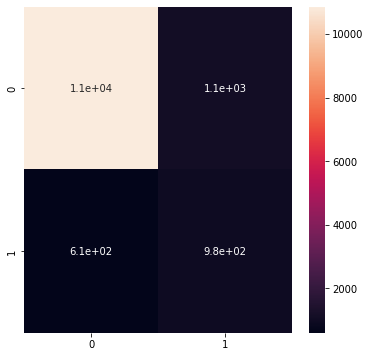

In [ ]:
cm = confusion_matrix(y_true = y_test_enc, y_pred = predictions)

plt.figure(figsize=(6,6));
sns.heatmap(cm, annot=True)
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

In [ ]:
wandb.log({"image_confusion_matrix": [wandb.Image('confusion_matrix.png')]})

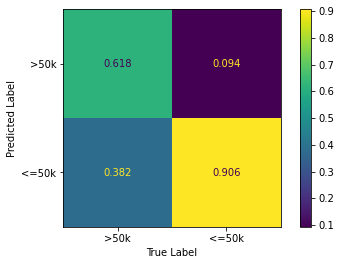

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions, y_test_enc,labels=[1,0], normalize="pred" ),
                       display_labels=[">50k","<=50k"]).plot(values_format='.3f',ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

20-07-2022 12:57:28 Uploading figures


## 2.2 Export the best keras model

In [ ]:
# types and names of the artifacts
artifact_keras_model = "keras_model_export"

In [ ]:
# Keras Model artifact
logger.info("save the artifacts to disk and wandb")
artifact = wandb.Artifact(artifact_keras_model,
                          type="inference_artifact",
                          description="MLP Model for Classification Purpose"
                          )

logger.info("Logging keras model artifact")
model.save("path")
artifact.add_dir("path")
run.log_artifact(artifact)

20-07-2022 12:57:38 save the artifacts to disk and wandb
20-07-2022 12:57:38 Logging keras model artifact
20-07-2022 12:57:39 Assets written to: path/assets
wandb: Adding directory to artifact (./path)... Done. 0.1s


In [ ]:
run.finish()

Acc,0.8726
F1,0.53145
Precision,0.46644
Recall,0.61752


Or Save keras model on run

In [ ]:
model.save(os.path.join(wandb.run.dir, "model.h5"))

In [ ]:
run.finish()